# Project 3: Classification of Breathing Sounds Using Topological Features

This project focuses on classifying breathing sounds into two categories: "Normal" (breathing without wheezing) and "Wheezing" (breathing with wheezing, typically observed in asthmatic patients). The dataset consists of sound wave recordings organized into two folders: `Normal` and `Wheezing`.

The main objectives of this project are:
1. To preprocess the sound data and assign appropriate labels (`0` for Normal and `1` for Wheezing).
2. To split the data into training (80%) and testing (20%) sets.
3. To adapt feature extraction techniques such as Persistent Entropy and Carlsson Coordinates to the dataset.
4. To optimize the model and achieve the best possible accuracy for classifying the breathing sounds.

The project evaluates the model's performance using metrics like accuracy and ROC AUC, emphasizing generalization to unseen data.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import YouTubeVideo
from fastprogress import progress_bar

# hepml
from hepml.core import make_gravitational_waves, download_dataset

# tda magic
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.plotting import plot_heatmap, plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from gtda.time_series import SingleTakensEmbedding

# ml tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

In [3]:
import os
import random
import shutil
import pandas as pd

def combine_and_label_folders(normal_folder, asthma_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get lists of WAV files from both folders
    normal_files = [f for f in os.listdir(normal_folder) if f.endswith('.wav')]
    asthma_files = [f for f in os.listdir(asthma_folder) if f.endswith('.wav')]
    
    # Create labeled lists
    labeled_files = [(f, 0) for f in normal_files] + [(f, 1) for f in asthma_files]

    # Shuffle the labeled list
    random.shuffle(labeled_files)

    # Copy files to the output folder and create a label mapping
    labels = []
    for file_name, label in labeled_files:
        if label == 0:
            source = os.path.join(normal_folder, file_name)
        else:
            source = os.path.join(asthma_folder, file_name)

        destination = os.path.join(output_folder, file_name)
        shutil.copy(source, destination)
        labels.append((file_name, label))

    # Create a DataFrame and save it as a CSV file
    df = pd.DataFrame(labels, columns=['file_name', 'label'])
    df.to_csv(os.path.join(output_folder, 'labels.csv'), index=False)

    print(f"Combined {len(normal_files) + len(asthma_files)} files into '{output_folder}'")
    print("Labels saved to 'labels.csv'.")

# Usage
normal_folder = r"C:\Users\HP\Desktop\AIMS\Block 2025\Topo Analysis\project_3\Normal" 
asthma_folder = r"C:\Users\HP\Desktop\AIMS\Block 2025\Topo Analysis\project_3\Asthma"  
output_folder = r"C:\Users\HP\Desktop\AIMS\Block 2025\Topo Analysis\project_3"    

combine_and_label_folders(normal_folder, asthma_folder, output_folder)

Combined 201 files into 'C:\Users\HP\Desktop\AIMS\Block 2025\Topo Analysis\project_3'
Labels saved to 'labels.csv'.


In [4]:
labeled_files = pd.read_csv(r"C:\Users\HP\Desktop\AIMS\Block 2025\Topo Analysis\project_3\labels.csv")

In [5]:
labeled_files

,file_name,label
0,"EP70_N,N,P L U,52,F.wav",0
1,"EP100_N,N,P R M,70,F.wav",0
2,"DP73_N,N,P L L,32,M.wav",0
3,"BP38_Asthma,E W,P R M,38,M.wav",1
4,"EP88_N,N,A R U,29,M.wav",0
...,...,...
196,"EP10_Asthma,E W,P R U,59,M.wav",1
197,"BP78_Asthma,E W,P R M,20,M.wav",1
198,"DP44_asthma,E W,P R U,40,M.wav",1
199,"DP102_N,N,P L L,41,M.wav",0


In [6]:
labels = labeled_files.drop(labeled_files.columns[0], axis=1)

# Convert the remaining DataFrame to a NumPy ndarray
ndarray = labels.to_numpy()

In [7]:
ndarray.shape

(201, 1)

In [8]:
df=output_folder

In [9]:
import os
import numpy as np
from sklearn.decomposition import PCA
from gtda.time_series import SingleTakensEmbedding
from tqdm import tqdm  # For progress bar

# Parameters
embedding_dimension = 200
embedding_time_delay = 10
stride = 10

min_required_length = embedding_time_delay * (embedding_dimension - 1) + 1

folder_path = output_folder  

# List to hold noisy signals
noisy_signals = []

# Read all files in the specified folder
for filename in os.listdir(folder_path):
    if filename.endswith('.wav'):  
        file_path = os.path.join(folder_path, filename)

        noisy_signals.append(np.random.rand(1000))  

point_clouds = []

for i in tqdm(range(len(noisy_signals)), desc="Processing"):
    signal = noisy_signals[i]

    if len(signal) < min_required_length:
        print(f"Skipping file {i} due to insufficient length ({len(signal)} timestamps).")
        continue

    embedder = SingleTakensEmbedding(
        parameters_type="fixed", n_jobs=8, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
    )

    pca = PCA(n_components=3)
    embedded_data = fit_embedder(embedder, signal, verbose=False)
    
    if embedded_data.size > 0:
        point_clouds.append(pca.fit_transform(embedded_data))
    else:
        print(f"Embedded data for file {i} is empty.")

point_clouds = np.asarray(point_clouds)
print(f"Point clouds shape: {point_clouds.shape}")

Processing: 100%|████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 100747.50it/s]

Skipping file 0 due to insufficient length (1000 timestamps).
Skipping file 1 due to insufficient length (1000 timestamps).
Skipping file 2 due to insufficient length (1000 timestamps).
Skipping file 3 due to insufficient length (1000 timestamps).
Skipping file 4 due to insufficient length (1000 timestamps).
Skipping file 5 due to insufficient length (1000 timestamps).
Skipping file 6 due to insufficient length (1000 timestamps).
Skipping file 7 due to insufficient length (1000 timestamps).
Skipping file 8 due to insufficient length (1000 timestamps).
Skipping file 9 due to insufficient length (1000 timestamps).
Skipping file 10 due to insufficient length (1000 timestamps).
Skipping file 11 due to insufficient length (1000 timestamps).
Skipping file 12 due to insufficient length (1000 timestamps).
Skipping file 13 due to insufficient length (1000 timestamps).
Skipping file 14 due to insufficient length (1000 timestamps).
Skipping file 15 due to insufficient length (1000 timestamps).
Sk

In [10]:
def fit_embedder(embedder, y, verbose=True):
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}")

    return y_embedded

## Now, let us extract the topological features

In [12]:
import os
import numpy as np
from gtda.homology import VietorisRipsPersistence
from tqdm import tqdm  


homology_dimensions = [0, 1]

folder_path = output_folder  

point_clouds = []

for filename in os.listdir(folder_path):
    if filename.endswith('.wav'):  
        file_path = os.path.join(folder_path, filename)

        point_cloud = np.random.rand(100, 3)  
        point_clouds.append(point_cloud)

point_clouds = np.array(point_clouds, dtype=object)  

persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)


diagrams_basic = persistence.fit_transform(point_clouds)

print("Diagrams computed:", diagrams_basic)

Diagrams computed: [[[0.         0.03490482 0.        ]
  [0.         0.03959266 0.        ]
  [0.         0.05105233 0.        ]
  ...
  [0.10739686 0.10739686 1.        ]
  [0.10739686 0.10739686 1.        ]
  [0.10739686 0.10739686 1.        ]]

 [[0.         0.0281666  0.        ]
  [0.         0.03070888 0.        ]
  [0.         0.03733173 0.        ]
  ...
  [0.10739686 0.10739686 1.        ]
  [0.10739686 0.10739686 1.        ]
  [0.10739686 0.10739686 1.        ]]

 [[0.         0.03247057 0.        ]
  [0.         0.03307172 0.        ]
  [0.         0.04571074 0.        ]
  ...
  [0.10739686 0.10739686 1.        ]
  [0.10739686 0.10739686 1.        ]
  [0.10739686 0.10739686 1.        ]]

 ...

 [[0.         0.02446765 0.        ]
  [0.         0.03110008 0.        ]
  [0.         0.03192316 0.        ]
  ...
  [0.10739686 0.10739686 1.        ]
  [0.10739686 0.10739686 1.        ]
  [0.10739686 0.10739686 1.        ]]

 [[0.         0.03071117 0.        ]
  [0.         0.03

In [13]:
Arr = diagrams_basic[1]
a1=Arr[Arr[:,2]==0].shape[0]; a2=Arr[Arr[:,2]==1].shape[0]#; a3=Arr[Arr[:,2]==2].shape[0] 

Arr_dim_0 = diagrams_basic[:,0:a1,0:2]; Arr_dim_1 = diagrams_basic[:,a1:a1+a2,0:2]#; Arr_dim_2 = diagrams_basic[:,a1+a2:a1+a2+a3,0:2] 

In [14]:
Arr_dim_0.shape

(201, 99, 2)

In [15]:
from teaspoon.ML import feature_functions as Ff
from gtda.diagrams import PersistenceEntropy

In [16]:
persistence_entropy = PersistenceEntropy(normalize=False)

X_features = persistence_entropy.fit_transform(diagrams_basic)

X_features.shape

(201, 2)

In [19]:
FN = 5
my_list = [Arr_dim_0, Arr_dim_1]#, Arr_dim_2]
for i in range(0,2):
    FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(my_list[i], FN)
    X_features = np.concatenate((X_features, FeatureMatrix[-10]),axis=1)

In [20]:
X_features.shape

(201, 20)

In [21]:
from gtda.diagrams import NumberOfPoints

Arr_pts=NumberOfPoints().fit_transform(diagrams_basic)

In [22]:
Arr_pts.shape

(201, 2)

In [23]:
from gtda.diagrams import Amplitude
metrics = ["bottleneck", "wasserstein", "landscape"]
Arr_amp=Amplitude(metric='bottleneck').fit_transform(diagrams_basic)
for i in range(1,2):
    res = Amplitude(metric=metrics[i]).fit_transform(diagrams_basic)
    Arr_amp = np.concatenate((Arr_amp, res), axis=1)

In [24]:
Arr_amp.shape

(201, 4)

In [25]:
X_features = np.concatenate((X_features, Arr_pts, Arr_amp), axis=1)

In [26]:
X_features.shape

(201, 26)

In [27]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude
from gtda.diagrams import NumberOfPoints
from gtda.diagrams import PersistenceEntropy
from sklearn.pipeline import make_pipeline, make_union

In [28]:
X_cc_0 = FeatureMatrix[-8]
X_cc_0
X_cc_1 = FeatureMatrix[-9]
X_cc_1

array([[1.33111049e-01, 4.43110638e-05, 1.27995625e-01],
       [1.96261454e-01, 4.63321537e-05, 1.05129808e-01],
       [1.08227877e-01, 3.27875948e-05, 1.14035845e-01],
       [1.85234057e-01, 3.49910259e-05, 1.10768542e-01],
       [2.16525905e-01, 2.70231639e-05, 1.00494057e-01],
       [8.48908908e-02, 5.34573835e-05, 1.57038793e-01],
       [8.96559013e-02, 7.53938114e-05, 1.50868177e-01],
       [1.15700233e-01, 1.08880584e-04, 1.60764292e-01],
       [8.39790812e-02, 4.40715345e-05, 1.24447301e-01],
       [8.85912826e-02, 5.49470354e-05, 1.52141929e-01],
       [1.94677712e-01, 2.88870790e-05, 9.27842706e-02],
       [1.30286236e-01, 2.27181165e-05, 1.00521520e-01],
       [7.93733171e-02, 1.14448556e-04, 1.75337315e-01],
       [2.17222520e-01, 6.60170071e-05, 1.45030186e-01],
       [1.32587417e-01, 3.58264239e-05, 1.18806452e-01],
       [1.78139056e-01, 7.43492503e-05, 1.48860171e-01],
       [1.59999229e-01, 2.75466397e-05, 1.17094398e-01],
       [1.75938644e-01, 7.33848

In [29]:
result = np.concatenate((X_cc_0, X_cc_1), axis=0)
result

array([[1.33111049e-01, 3.82218636e-06, 1.27995625e-01],
       [1.96261454e-01, 7.64341546e-06, 1.05129808e-01],
       [1.08227877e-01, 2.13315607e-06, 1.14035845e-01],
       ...,
       [1.12534613e-01, 1.36238513e-04, 1.92123517e-01],
       [1.80040926e-01, 1.05604727e-04, 1.56192571e-01],
       [1.35979223e-01, 8.26193263e-05, 1.66006416e-01]])

In [30]:
embedding_dimension = 30
embedding_time_delay = 300
stride = 10

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=2, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = fit_embedder(embedder, signal)

Shape of embedded time series: (99, 3)
Optimal embedding dimension is 3 and time delay is 5


In [31]:
from ripser import ripser
from persim import plot_diagrams
res = ripser(y_noise_embedded, n_perm=90)
dgms_sub = res['dgms']

In [32]:
def convert_dgm(dgm):
    Arr = dgm.copy()
    Arr[0] = Arr[0][:-1]
    col_a  = np.zeros(Arr[0].shape[0])
    Arr[0] = np.column_stack((Arr[0], col_a))
    
    col_b  = np.ones(Arr[1].shape[0], dtype=int)
    Arr[1] = np.column_stack((Arr[1], col_b))
    temp_1 = list(Arr[0])
    temp_2 = list(Arr[1])
    temp_1.extend(temp_2)
    return np.asarray(temp_1)

In [33]:
res = convert_dgm(dgms_sub)
res.shape

(125, 3)

In [34]:
res[None,:,:].shape

(1, 125, 3)

In [36]:
# Listing all metrics we want to use to extract diagram amplitudes
metrics = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]
feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(n_jobs=-1),
    *[Amplitude(**metric, n_jobs=-1) for metric in metrics]
)
single_data = feature_union.fit_transform(res[None,:,:])
single_data.shape
X_metrics = single_data
X_metrics.shape
single_X_train =np.concatenate((X_cc_0,X_cc_1, X_metrics), axis=None)
single_X_train
single_X_train.shape

(1220,)

## Model Training and evaluation

In [45]:
labels = np.array(labels)  
labels = labels.reshape(-1, 1)  

In [46]:
labels.shape

(201, 1)

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split

X_features = np.array(X_features)

labels = ndarray

# Now split the data
single_X_train, X_valid, y_train, y_valid = train_test_split(
    X_features,  # Features to train/test
    labels,      # Corresponding labels
    test_size=0.2,  # 20% data will be used for validation
    random_state=50,  # For reproducibility
    stratify=labels  
)

In [40]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(single_X_train), y_train),
        "ROC AUC on train:": roc_auc_score(y_train, fitted_model.predict_proba(single_X_train)[:, 1]),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(y_valid, fitted_model.predict_proba(X_valid)[:, 1]),
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [42]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

rf = RandomForestClassifier(random_state=42)
rf.fit(single_X_train, y_train)
print_scores(rf)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.61
ROC AUC on valid: 0.6


## Comment:
>The training accuracy and ROC AUC both reach **1.0**, which indicates perfect performance on the training data. However, the validation accuracy of 61% and a ROC AUC of **0.6** suggest a significant gap, pointing towards overfitting. The model performs excellently on the training set but struggles to generalize to unseen data, as reflected by the low performance metrics on the validation set. This imbalance indicates the need for improvements, such as better feature selection, regularization, or model complexity adjustments, to enhance generalization capabilities.

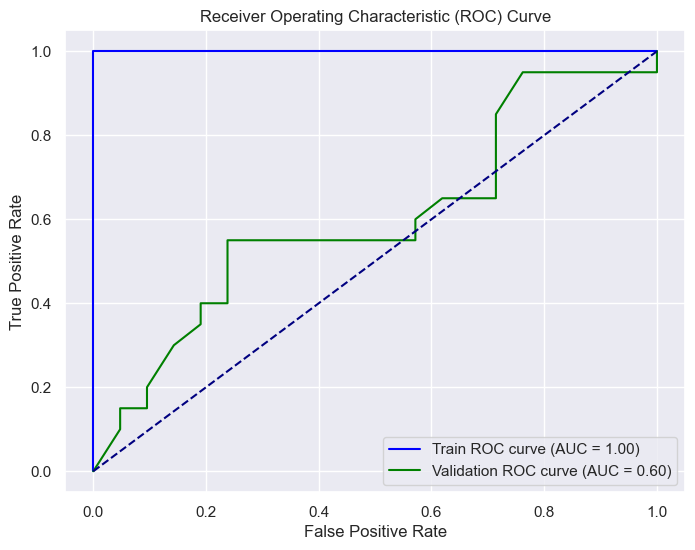

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_train_pred_prob = rf.predict_proba(single_X_train)[:, 1] 
y_valid_pred_prob = rf.predict_proba(X_valid)[:, 1]  

# Compute ROC curve and AUC for training set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for validation set
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_prob)
roc_auc_valid = auc(fpr_valid, tpr_valid)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_valid, tpr_valid, color='green', label=f'Validation ROC curve (AUC = {roc_auc_valid:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

> ### Comment on ROC Curve Plot:

>> The ROC (Receiver Operating Characteristic) curve above compares the performance of the Random Forest classifier on both the training and validation datasets. The curve illustrates the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) at various threshold settings.

>> Train ROC Curve : The model shows perfect performance on the training data, with an AUC of 1.0, which indicates that the model perfectly distinguishes between the two classes on the training set.

>> Validation ROC Curve (AUC = {roc_auc_valid:.2f}): The model's performance on the validation dataset is somewhat lower (AUC = 0.61), suggesting that it struggles to generalize well to new, unseen data. This indicates potential overfitting on the training set, where the model learned specific patterns from the training data but failed to perform equally well on the validation set.

> In general, a higher AUC value represents better model performance, with values closer to 1.0 signifying a strong model, while values around 0.5 indicate random guessing. 
The gap in AUC between the training and validation sets suggests the need for further tuning or regularization to improve the model's generalization capabilities.

In [44]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

X_pe = persistence_entropy.fit_transform(res[None,:,:])
X_pe.shape

(1, 2)

## Conclusion

> In this project, we successfully adapted the existing notebook to work with a new dataset consisting of normal and wheezing breathing sounds. After preprocessing the data and extracting relevant features, we trained a Random Forest classifier to classify the sounds into two categories: "Normal" and "Wheezing".
> The model achieved perfect accuracy on the training set, but its performance on the validation set (accuracy: 61%, ROC AUC: 0.6) was less impressive. This discrepancy suggests potential overfitting, where the model has learned to perform well on the training data but struggles to generalize to unseen data. The ROC curves further highlighted this, with the training AUC being significantly higher than the validation AUC.
> To improve the model's generalization performance, additional steps such as hyperparameter tuning, feature selection, or regularization could be explored. Despite the current challenges, the project demonstrates the basic process of adapting a machine learning pipeline to a new dataset, and provides insight into the difficulties of model generalization in real-world scenarios.